In [29]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import *

From Wikipedia, the Bethe-Bloch formula is given by 
$$- \left\langle\frac{dE}{dx}\right\rangle = \frac{4 \pi}{m_e c^2} \frac{nz^2}{\beta^2}\left(\frac{e^2}{4\pi\varepsilon_0}\right)^2 \left[\ln \left(\frac{2m_e c^2 \beta^2}{I  (1-\beta^2)}\right) - \beta^2\right]$$

where $n = \frac{N_AZ\rho}{A}$ and $I_{Cu}/Z_{Cu} = 11 eV$, $I_{C}/Z_{C} = 15 eV$.

In [30]:
def electronDensity(Z, rho, A):
    return N_A * Z * rho /(A*1.)

def betheBlochFormula(n, z, I, beta = 0.9998):
    toreturn = 4*np.pi/(m_e*c**2) * n*z**2 /(beta**2) * (e**2/(4*np.pi*epsilon_0))**2\
    * (np.log(2*m_e*c**2*beta**2/(I*(1-beta**2)))-beta**2)
    return -1*toreturn

In [31]:
copper_density = 8920. #kg/m3
plastic_density = 940. #kg/m3  Low/High density Polyethilene
copper_I = 11*29*e #Joules
plastic_I = 15*6*e #Joules
copper_elec_dens = electronDensity(29, copper_density, 63.54)
plastic_elec_dens = electronDensity(6, plastic_density, 12)

In [32]:
print 'For Cu', -betheBlochFormula(copper_elec_dens, 1, copper_I)/e *1e-6, 'MeV'
print 'For C (Plastic)', -betheBlochFormula(plastic_elec_dens, 1, plastic_I)/e *1e-6, 'MeV'

For Cu 1.86298756486643 MeV
For C (Plastic) 0.23334606184953993 MeV


# Initial calibration with unknown threshold

In [33]:
import pandas as pd
from scipy import stats
from scipy.optimize import fsolve


In [34]:
raw_data = pd.read_excel('PMT_calib_fixed.xlsx')

def extract_data(r_data, PMT_num):
    PMT_data = r_data[r_data['PMT']==PMT_num]
    PMT_data = PMT_data.drop('PMT', axis=1)
    PMT_data = PMT_data.set_index(PMT_data['Voltage [V]'])
    PMT_data = PMT_data.sort_values('Voltage [V]')
    PMT_matrix = PMT_data.as_matrix()
    return PMT_matrix

In [35]:
matrices = [extract_data(raw_data, i) for i in range(1, 5)]

In [36]:
def line(x, m, b, des):
    return m*x + b - des

def get_calibrating_voltage(PMT_matrix, desired_count):
    V_data = PMT_matrix[:,0]
    count_data = PMT_matrix[:,1]
    log_count_data = np.log(count_data)
    V_mask=[v<=2.3 and v>=2 for v in V_data]
    V_data = V_data[V_mask]
    log_count_data = log_count_data[V_mask]
    plt.plot(V_data, log_count_data)
    slope, intercept, r_value, p_value, std_err = stats.linregress(V_data, log_count_data)
    plt.plot(np.linspace(2, 2.4, 100), slope*np.linspace(2, 2.4, 100)+intercept)
    print slope, intercept
    return fsolve(line, 2, (slope, intercept, desired_count))
    

10.958842155377365 -13.956723702263885
9.726194692053483 -12.396849923273296
11.976162611056242 -17.19367575838576
11.512213778591176 -15.755479007997733


[(1, 2.1404381384172018),
 (2, 2.2513275352346698),
 (3, 2.2289005773637784),
 (4, 2.193798646700288)]

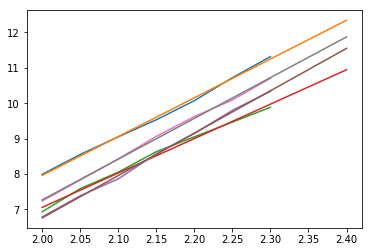

In [37]:
[(i+1,get_calibrating_voltage(matrix, 9.5)[0]) for i, matrix in enumerate(matrices)]

# Calibración Threshold

    Threshold (V)  Counts (10s) source  Counts (10s) no source
31           0.29                84670                   16311
30           1.07                53838                    8590
29           1.22                46825                    6775
28           1.43                39568                    5306
27           1.64                34844                    4272
26           1.83                32054                    3568
25           1.98                30379                    3238
24           2.11                28973                    3148
23           2.25                27921                    2838
22           2.38                26928                    2648
21           2.60                25892                    2624
20           2.70                25353                    2384
19           2.89                24518                    2173
18           3.03                24256                    2073
17           3.19                23269                 

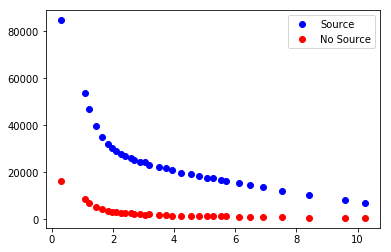

In [38]:
raw_data = pd.read_excel('Threshold_calib.xlsx')
raw_data= raw_data.sort_values('Threshold (V)')
mat = raw_data.as_matrix()
plt.plot(mat[:,0], mat[:,1], 'ob', label='Source')
plt.plot(mat[:,0], mat[:,2], 'or', label='No Source')
plt.legend(loc=0)
print raw_data

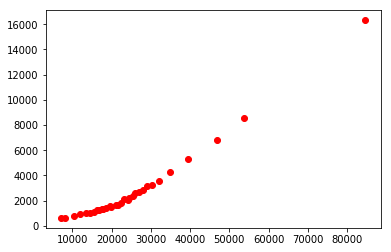

In [39]:
plt.plot(mat[:,1], mat[:,2], 'or', label='Source vs. No Source')

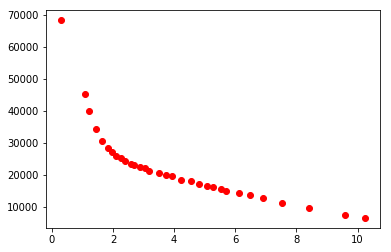

In [40]:
plt.plot(mat[:,0], mat[:,1]-mat[:,2], 'or', label='Source - No Source')


+ Compton scattering: Relation between incoming photon and electron energy
+ Muon decay products' energy
+ More precise threshold measurements


In [41]:
def electron_E(E_gamma):
    return E_gamma*(1-1./(1+2*(E_gamma/(511e-3))))

In [42]:
gamma_energies = [1.17, 1.33]
print [electron_E(E) for E in gamma_energies], 'MeV'

[0.9602946334619431, 1.115673289183223] MeV


# Cumulative Espectrum

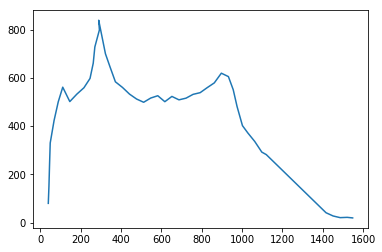

In [43]:
from scipy import interpolate
spectrum = np.loadtxt('Co_Spectrum.csv', delimiter =',')
evaluate_spectrum = interpolate.interp1d(spectrum[:,0], spectrum[:,1])
plt.plot(spectrum[:,0], spectrum[:,1])

In [44]:
print evaluate_spectrum(1.5e3)

20.72740514025399


In [45]:
#This function can either print or store the markov chain. For parallel computing it is easier to print.
def MH_Spectrum_Sampling(spectrum, niter):
    evaluate_spectrum = interpolate.interp1d(spectrum[:,0], spectrum[:,1])
    markov_chain=[]
    max_interval=spectrum[:,0][-1]
    initial_value=max_interval*np.random.random()
    #print initial_value
    markov_chain.append(initial_value)
    for i in range(niter):
        std = 10**(np.log10(spectrum[:,0][-1]))
        to_try = np.random.normal(markov_chain[i], std)
        while(to_try<spectrum[:,0][0] or to_try>spectrum[:,0][-1]):
            to_try = np.random.normal(markov_chain[i], std)
        possible_jump=to_try
        criteria = evaluate_spectrum(possible_jump)/evaluate_spectrum(markov_chain[i])
        if(criteria>=1.):
            #print abs(possible_jump)
            markov_chain.append(abs(possible_jump))
        else:
            other_random = np.random.random()
            if(other_random<=criteria):
                #print possible_jump
                markov_chain.append(possible_jump)
            else:
                #print markov_chain[i]
                markov_chain.append(markov_chain[i])
    return np.array(markov_chain)

In [46]:
markov = MH_Spectrum_Sampling(spectrum, 10000)


(array([1.00000000e+00, 9.91000900e-01, 9.78402160e-01, 9.61103890e-01,
        9.41005899e-01, 9.25107489e-01, 9.09509049e-01, 8.95310469e-01,
        8.79512049e-01, 8.61013899e-01, 8.39016098e-01, 8.16218378e-01,
        7.87721228e-01, 7.61123888e-01, 7.35726427e-01, 7.11628837e-01,
        6.92230777e-01, 6.74632537e-01, 6.53234677e-01, 6.35636436e-01,
        6.14138586e-01, 5.95840416e-01, 5.77842216e-01, 5.61043896e-01,
        5.45845415e-01, 5.28147185e-01, 5.09649035e-01, 4.94150585e-01,
        4.76752325e-01, 4.59654035e-01, 4.42055794e-01, 4.24257574e-01,
        4.04859514e-01, 3.86661334e-01, 3.66463354e-01, 3.47965203e-01,
        3.27967203e-01, 3.06169383e-01, 2.86371363e-01, 2.67573243e-01,
        2.43575642e-01, 2.19478052e-01, 1.96580342e-01, 1.73682632e-01,
        1.57784222e-01, 1.42685731e-01, 1.29287071e-01, 1.16588341e-01,
        1.05189481e-01, 9.13908609e-02, 8.20917908e-02, 7.28927107e-02,
        6.33936606e-02, 5.54944506e-02, 4.67953205e-02, 4.019598

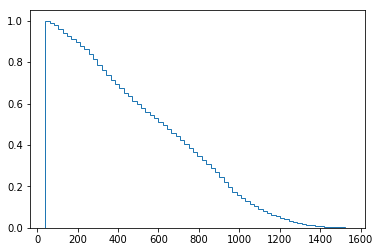

In [47]:
#plt.hist(markov, bins = 70, histtype='step')
plt.hist(markov, bins = 70, histtype='step', cumulative=-1, normed=True)

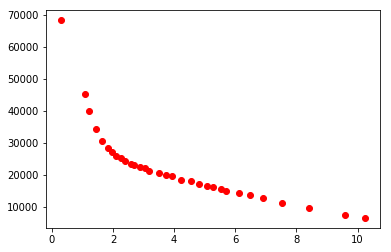

In [48]:
plt.plot(mat[:,0], mat[:,1]-mat[:,2], 'or', label='Source - No Source')


In [49]:
measured_spectrum = np.column_stack((mat[:,0], mat[:,1]-mat[:,2]))


[[2.9000e-01 6.8359e+04]
 [1.0700e+00 4.5248e+04]
 [1.2200e+00 4.0050e+04]
 [1.4300e+00 3.4262e+04]
 [1.6400e+00 3.0572e+04]
 [1.8300e+00 2.8486e+04]
 [1.9800e+00 2.7141e+04]
 [2.1100e+00 2.5825e+04]
 [2.2500e+00 2.5083e+04]
 [2.3800e+00 2.4280e+04]
 [2.6000e+00 2.3268e+04]
 [2.7000e+00 2.2969e+04]
 [2.8900e+00 2.2345e+04]
 [3.0300e+00 2.2183e+04]
 [3.1900e+00 2.1152e+04]
 [3.5000e+00 2.0552e+04]
 [3.7200e+00 1.9963e+04]
 [3.9200e+00 1.9507e+04]
 [4.2200e+00 1.8392e+04]
 [4.5400e+00 1.7891e+04]
 [4.8000e+00 1.7112e+04]
 [5.0800e+00 1.6387e+04]
 [5.2700e+00 1.6222e+04]
 [5.5200e+00 1.5394e+04]
 [5.7100e+00 1.4958e+04]
 [6.1300e+00 1.4277e+04]
 [6.4900e+00 1.3566e+04]
 [6.9200e+00 1.2606e+04]
 [7.5200e+00 1.1130e+04]
 [8.4200e+00 9.5730e+03]
 [9.6000e+00 7.4120e+03]
 [1.0250e+01 6.4500e+03]]


[ 0.29  1.07  1.22  1.43  1.64  1.83  1.98  2.11  2.25  2.38  2.6   2.7
  2.89  3.03  3.19  3.5   3.72  3.92  4.22  4.54  4.8   5.08  5.27  5.52
  5.71  6.13  6.49  6.92  7.52  8.42  9.6  10.25]


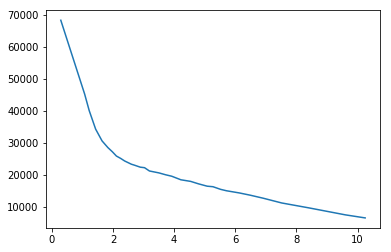

In [50]:

evaluate_measured_spectrum = interpolate.interp1d(measured_spectrum[:,0], measured_spectrum[:,1])#, kind = 'cubic')
plt.plot(measured_spectrum[:,0], measured_spectrum[:,1])
markov = MH_Spectrum_Sampling(measured_spectrum, 10000)


[418. 282. 420. 291. 249. 267. 275. 252. 164. 193. 160. 135. 131. 152.
 135. 146. 121. 121.  97.  99. 132. 118. 141. 104. 126. 120.  97. 118.
 125. 109. 116. 127. 100.  94.  90. 117. 107. 113.  95. 103.  87. 107.
  99.  91.  90.  96. 112.  92.  61.  83.  86.  74.  78.  80.  92.  63.
  70.  67.  65.  70.  79.  77.  47.  65.  74.  71.  60.  65.  52.  70.
  65.  66.  59.  58.  56.  48.  53.  46.  39.  50.  46.  60.  44.  46.
  57.  43.  42.  32.  35.  31.  38.  41.  28.  31.  39.  37.  32.  29.
  31.  36.]


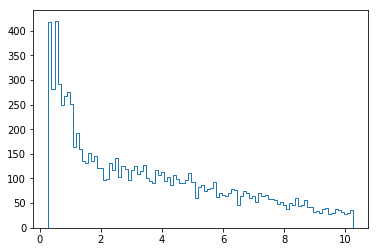

In [51]:
freqs, bins, ax = plt.hist(markov, bins = 100, histtype='step')
#plt.hist(markov, bins = 70, histtype='step', cumulative=-1, normed=True)


In [52]:
uncumulated = [freqs[i]-freqs[i+1] for i in range(len(freqs)-1)]

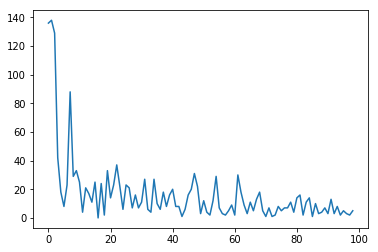

In [53]:
plt.plot(abs(np.array(uncumulated)))

In [54]:
freqs = evaluate_measured_spectrum(np.linspace(0.29, 10.24, 100))
uncumulated = [freqs[i]-freqs[i+1] for i in range(len(freqs)-1)]
print freqs

[68359.         65381.08689459 62403.17378917 59425.26068376
 56447.34757835 53469.43447293 50491.52136752 47513.60826211
 44414.91986532 40932.08484848 37981.46512747 35211.35449735
 33101.22077922 31335.2034632  29945.42371079 28841.98405104
 27875.54208754 26952.85392385 25935.43356643 25350.14141414
 24773.52991453 24185.21212121 23722.88888889 23263.16767677
 22962.03349282 22631.95374801 22329.80519481 22213.50649351
 21705.25126263 21123.65200391 20929.12609971 20734.6001955
 20535.50367309 20266.42424242 19997.34481175 19763.0969697
 19533.94545455 19177.38047138 18803.83670034 18430.29292929
 18250.77746212 18093.42424242 17936.07102273 17676.12432012
 17374.9957265  17079.04545455 16818.80916306 16558.57287157
 16357.26315789 16269.98245614 16072.12363636 15739.25090909
 15406.37818182 15171.943647   14946.20779221 14783.24603175
 14620.28427128 14457.32251082 14294.36075036 14099.6489899
 13901.15151515 13702.6540404  13496.09161381 13271.70824524
 13047.32487667 12822.94150

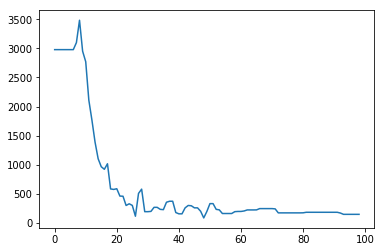

In [55]:
plt.plot(uncumulated)

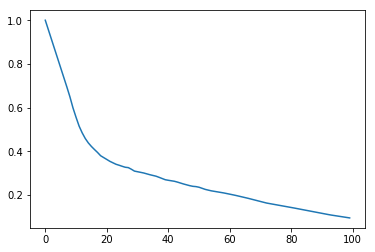

In [56]:
plt.plot(freqs/max(freqs))